In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from collections import defaultdict
import json
import numpy as np
import pandas as pd
import re
import seaborn as sb
sb.set()

In [2]:
def is_experiment_start(line):
    return line.startswith('evaluating for')

def skip_n_experiments(input_file, experiment_num):
    current_experiment = 0
    while current_experiment < experiment_num:
        line = input_file.readline()
        if is_experiment_start(line):
            current_experiment += 1
            
def get_metrics(line):
    regexp = re.compile(r'[a-zA-Z0-9_]+\: [0-9\.]+')
    result = {}
    for metric_str in regexp.findall(line):
        metric, value = metric_str.split(': ')
        result[metric] = float(value)
    return result
    
            
def parse_experiment(experiment_log):
    current_recommender = None
    result = []
    cnt =0
    metrics = []
    experiment_finished = True
    for line in experiment_log:
            if line.startswith('evaluating '):
                current_recommender = line.split(' ')[1]
                metrics = []
                experiment_finished = False
            if 'val_ndcg_at_40' in line:
                    metrics.append(get_metrics(line))
            try:
                experiment_results = json.loads(line)
                experiment_results['model_name'] =  current_recommender
                experiment_results['metrics_history'] = metrics
                result.append(experiment_results)
                experiment_finished = True
            except:
                pass
    if not experiment_finished:
        experiment_results = {}
        experiment_results['model_name'] =  current_recommender
        experiment_results['metrics_history'] = metrics
        result.append(experiment_results)
    return result

def get_data_from_logs(logfile, experiment_num):
    current_experiment = 0
    with open(logfile) as input_file:
        skip_n_experiments(input_file, experiment_num)
        experiment_log = []
        for line in input_file:
            if is_experiment_start(line):
                break
            else:
                experiment_log.append(line.strip())
        return parse_experiment(experiment_log)

In [12]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [6]:
experiment_logs = './results/mlp_config_with_lambdarank_2021_10_25T10_34_15/stdout'
data = get_data_from_logs(experiment_logs, 0)

In [8]:
df = pd.DataFrame(data).set_index('model_name').sort_values('ndcg@40')


In [9]:
df

,precision@5,ndcg@40,recall@5,SPS@10,apr@10,pairwise_cos_sim@10,model_build_time,model_inference_time,model_metadata,metrics_history
model_name,,,,,,,,,,
APREC-GMLPHE-BPR-sigmoid,0.00185,0.013407,0.00925,0.01400,241.420300,0.083517,4512.947305,78.945884,"{'epochs_trained': 239, 'best_val_ndcg': 0.012...","[{'loss': 66044.7734, 'ndcg_at_40': 0.0589, 'v..."
top_recommender,0.00640,0.042397,0.03200,0.05200,12.774425,0.304987,0.055338,0.636792,{'proxy_model': 'filter_seen_recommender'},[]
APREC-GMLPHE-BPR-linear,0.00630,0.046087,0.03150,0.05125,325.083475,0.160524,5027.022566,80.947721,"{'epochs_trained': 283, 'best_val_ndcg': 0.035...","[{'loss': 19741.8574, 'ndcg_at_40': 0.1306, 'v..."
APREC-GMLPHE-XENDCG-linear,0.00980,0.061411,0.04900,0.07275,108.045300,0.240212,1205.300905,81.762466,"{'epochs_trained': 51, 'best_val_ndcg': 0.0497...","[{'loss': 9.7871, 'ndcg_at_40': 0.1469, 'val_l..."
APREC-GMLPHE-BCE,0.00895,0.062662,0.04475,0.07475,345.939175,0.169077,3546.673440,81.002024,"{'epochs_trained': 344, 'best_val_ndcg': 0.050...","[{'loss': 0.0798, 'ndcg_at_40': 0.1121, 'val_l..."
APREC-GMLPHE-XENDCG-sigmoid,0.00930,0.063795,0.04650,0.07900,114.689950,0.230148,3183.594074,81.792111,"{'epochs_trained': 297, 'best_val_ndcg': 0.045...","[{'loss': 9.7872, 'ndcg_at_40': 0.1384, 'val_l..."
lightfm_30_WARP,0.00885,0.064816,0.04425,0.07250,754.533950,0.105344,32.511504,13.774024,{'proxy_model': 'filter_seen_recommender'},[]
lightfm_30_BPR,0.00925,0.065238,0.04625,0.07300,734.056225,0.106866,32.286319,13.774907,{'proxy_model': 'filter_seen_recommender'},[]
svd_recommender_30,0.01085,0.069596,0.05425,0.08100,63.118075,0.241089,2.603842,14.446721,{'proxy_model': 'filter_seen_recommender'},[]


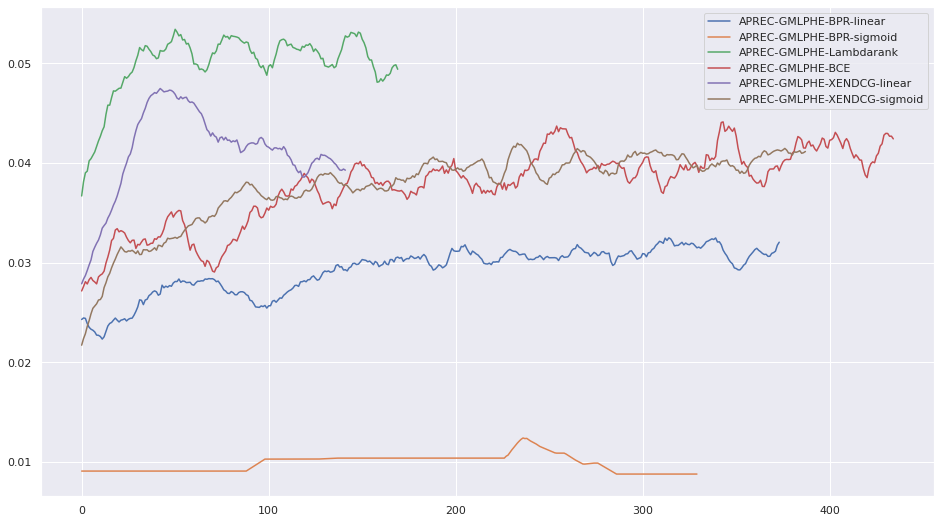

In [16]:
def get_metric(metric_history, metric_name):
    result = []
    for item in metric_history:
        try:
            result.append(item[metric_name])
        except:
            print(item)
    return result

plt.figure(figsize=(16, 9))
for recommender in data:
    if len(recommender['metrics_history']) > 0:
        history = recommender['metrics_history']
        ndcg = get_metric(history, 'ndcg_at_40')
        val_ndcg = moving_average(get_metric(history, 'val_ndcg_at_40'), 10)
        
        #success = get_metric(history, 'Success_at_4')
        #val_success = moving_average(get_metric(history, 'val_Success_at_4'), 5)
        
        #plt.plot(val_success, label=recommender['model_name'] + "val_sps")
        #plt.plot(success, label=recommender['model_name'] + "sps")
        
        plt.plot(val_ndcg, label=recommender['model_name'])
        #plt.plot(ndcg, label=recommender['model_name'] + "ndcg")
        #plt.plot(val_success, label=recommender['model_name'] + "_val_sps")
plt.legend()


In [17]:
np.argmax(val_ndcg)

233

In [ ]:
plt.scatter(df['SPS@4'], df['ndcg@40'])
